<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week4/MHEALTH_1DCNN_LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import glob
import os
import warnings

warnings.filterwarnings('ignore')

In [18]:
# --- 1. 데이터 로드 및 병합 ---
print("--- 1. 데이터 로드 및 병합 시작 ---")
# Google Drive에 마운트된 데이터셋의 경로를 지정합니다.
path = '/content/drive/MyDrive/Colab Notebooks/MHEALTHDATASET'

if not os.path.isdir(path):
    print(f"⚠️ 오류: 디렉토리를 찾을 수 없습니다: {path}")
else:
    # 경로에서 mHealth_subject*.log 패턴을 가진 모든 파일을 찾습니다.
    all_files = sorted(glob.glob(os.path.join(path, "mHealth_subject*.log")))
    if not all_files:
        print(f"⚠️ 오류: '{path}' 디렉토리에서 'mHealth_subject*.log' 파일을 찾을 수 없습니다.")
    else:
        print(f"총 {len(all_files)}개의 사용자 파일을 찾았습니다.")
        li = []
        column_names = [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_lead1', 'ecg_lead2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'label'
        ]
        feature_cols = column_names[:-1]

        for filename in all_files:
            df_temp = pd.read_csv(filename, header=None, sep=r'\s+')
            df_temp.columns = column_names
            subject_id = int(''.join(filter(str.isdigit, os.path.basename(filename))))
            df_temp['subject'] = subject_id
            li.append(df_temp)

        df = pd.concat(li, axis=0, ignore_index=True)
        # Null class (label 0)는 활동이 아니므로 제거
        df = df[df['label'] != 0].reset_index(drop=True)

        print("✅ 데이터 로드 및 Null class 제거 완료")
        print(f"전체 데이터 모양: {df.shape}")
        print("데이터 예시:")
        display(df.head())

--- 1. 데이터 로드 및 병합 시작 ---
총 10개의 사용자 파일을 찾았습니다.
✅ 데이터 로드 및 Null class 제거 완료
전체 데이터 모양: (343195, 25)
데이터 예시:


,acc_chest_x,acc_chest_y,acc_chest_z,ecg_lead1,ecg_lead2,acc_ankle_x,acc_ankle_y,acc_ankle_z,gyro_ankle_x,gyro_ankle_y,...,acc_arm_y,acc_arm_z,gyro_arm_x,gyro_arm_y,gyro_arm_z,mag_arm_x,mag_arm_y,mag_arm_z,label,subject
0,-9.7788,0.55690,1.19750,0.008373,-0.033490,2.6493,-9.4517,0.37683,-0.20965,-0.88931,...,-9.0618,1.8177,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,1
1,-9.7733,0.27880,0.73036,-0.025118,-0.025118,2.4157,-9.5306,0.40179,-0.20965,-0.88931,...,-9.2048,1.5189,-0.058824,-0.93429,-0.34483,0.719910,0.17803,0.37363,1,1
2,-9.8609,0.11561,0.79988,0.025118,0.016745,2.3865,-9.5991,0.48141,-0.20037,-0.86867,...,-9.1945,1.5507,-0.058824,-0.93429,-0.34483,0.355370,-0.37003,-0.35020,1,1
3,-9.7409,0.17652,0.88957,0.180010,0.129770,2.3758,-9.5997,0.42919,-0.20037,-0.86867,...,-9.1746,1.5413,-0.078431,-0.93429,-0.34052,0.357180,-0.18858,-0.35198,1,1
4,-9.7821,0.21637,0.90368,0.092098,0.046049,2.3239,-9.5406,0.40038,-0.20037,-0.86867,...,-9.2039,1.6127,-0.078431,-0.93429,-0.34052,-0.001887,-0.18867,-0.72017,1,1


In [19]:
# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- 2. Exploratory Data Analysis (EDA) ---")
# Add activity names for better visualization
activity_mapping = {
    1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
    4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 8: 'Knees bending (crouching)',
    9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
}
df['activity'] = df['label'].map(activity_mapping)


--- 2. Exploratory Data Analysis (EDA) ---


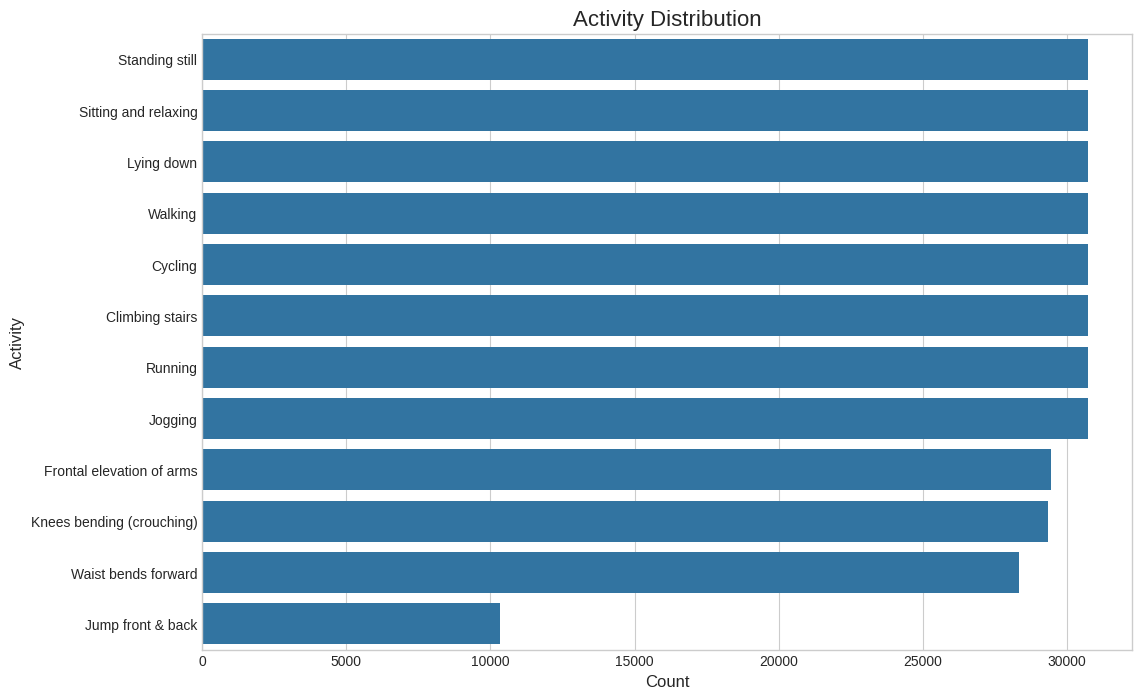

In [20]:
# Plot activity distribution
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))
sns.countplot(y='activity', data=df, order=df['activity'].value_counts().index)
plt.title('Activity Distribution', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.show()

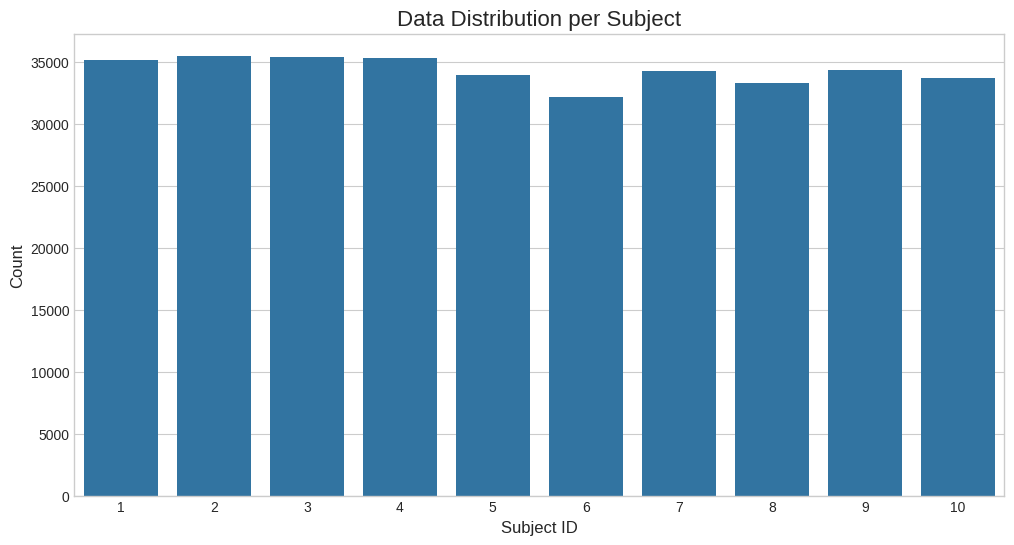

In [21]:
# Plot data distribution per subject
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', data=df)
plt.title('Data Distribution per Subject', fontsize=16)
plt.xlabel('Subject ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [22]:
# --- 3. Sliding Window Segmentation (Memory-Optimized Version from WISDM) ---
print("\n--- 3. Starting Sliding Window Segmentation ---")
def create_segments(df, time_steps, step, feature_cols):
    feature_values = df[feature_cols].values
    label_values = df['label'].values
    user_values = df['subject'].values

    num_segments = (len(df) - time_steps) // step + 1

    segments = np.empty((num_segments, time_steps, len(feature_cols)))
    labels = np.empty(num_segments, dtype=int)
    users = np.empty(num_segments, dtype=int)

    idx = 0
    for i in range(0, len(df) - time_steps + 1, step):
        segments[idx] = feature_values[i: i + time_steps]

        label_result = stats.mode(label_values[i: i + time_steps], keepdims=True).mode[0]
        labels[idx] = np.array(label_result).flatten()[0]

        users[idx] = user_values[i]

        idx += 1

    return segments, labels, users

# Parameters based on literature and data characteristics
Fs = 50
TIME_STEPS = int(Fs * 2.56)  # 128 (2.56 seconds)
STEP_SIZE = int(TIME_STEPS * 0.5) # 64 (50% overlap)


--- 3. Starting Sliding Window Segmentation ---


In [23]:
X, y, groups = create_segments(df, TIME_STEPS, STEP_SIZE, feature_cols)
# Adjust labels to start from 0 (original 1-12 -> 0-11)
y = y - 1
NUM_CLASSES = len(np.unique(y))

# Create a LabelEncoder for mapping names in the final report
le = LabelEncoder()
le.fit(list(activity_mapping.values()))


print(f"✅ Segments created successfully. Shape: X={X.shape}, y={y.shape}, groups={groups.shape}")
print(f"Number of classes: {NUM_CLASSES}")

✅ Segments created successfully. Shape: X=(5361, 128, 23), y=(5361,), groups=(5361,)
Number of classes: 12


In [24]:
# --- 4. CNN-LSTM Model Definition (Deeper and Tuned) ---
class HAR_CNN_LSTM_Deeper(nn.Module):
    def __init__(self, num_classes, num_features):
        super(HAR_CNN_LSTM_Deeper, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # Added another Conv layer
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # Increased LSTM hidden size and dropout
        self.lstm = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, batch_first=True, dropout=0.6)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

In [25]:
# --- 5. Subject-wise Cross-Validation ---
print("\n--- 5. Starting Subject-wise Cross-Validation ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Split 10 subjects into 5 folds of 2 subjects each
N_SPLITS = 5
gkf = GroupKFold(n_splits=N_SPLITS)

fold_results = []
fold_accuracies = []
all_preds = []
all_labels = []


--- 5. Starting Subject-wise Cross-Validation ---
Using device: cuda


In [26]:
for fold, (train_val_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n========== Fold {fold+1}/{N_SPLITS} ==========")

    model = HAR_CNN_LSTM_Deeper(NUM_CLASSES, X.shape[2]).to(device)
    criterion = nn.CrossEntropyLoss()
    # Tuned learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]

    # Data Scaling (based on training data for this fold)
    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val.reshape(-1, X_train_val.shape[2])).reshape(X_train_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val)

    # Reshape for CNN input: (N, length, channels) -> (N, channels, length)
    X_train = X_train.transpose(0, 2, 1)
    X_val = X_val.transpose(0, 2, 1)
    X_test = X_test.transpose(0, 2, 1)

    # Create Tensors and DataLoaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Model Training
    NUM_EPOCHS = 30 # Increased epochs
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for segments, labels in train_loader:
            segments, labels = segments.to(device), labels.to(device)
            outputs = model(segments)
            loss = criterion(outputs, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)

        model.eval()
        running_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for segments, labels in val_loader:
                segments, labels = segments.to(device), labels.to(device)
                outputs = model(segments)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    fold_results.append(history)

    # Model Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for segments, labels in test_loader:
            segments, labels = segments.to(device), labels.to(device)
            outputs = model(segments)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    fold_accuracies.append(accuracy)
    print(f'✅ Fold {fold+1} Test Accuracy: {accuracy:.2f} %')


========== Fold 1/5 ==========
Epoch [1/30], Train Loss: 1.7434, Train Acc: 36.71%, Val Loss: 0.8736, Val Acc: 71.00%
Epoch [2/30], Train Loss: 0.5386, Train Acc: 80.01%, Val Loss: 0.4162, Val Acc: 87.24%
Epoch [3/30], Train Loss: 0.2093, Train Acc: 94.19%, Val Loss: 0.0940, Val Acc: 97.68%
Epoch [4/30], Train Loss: 0.0803, Train Acc: 98.17%, Val Loss: 0.1359, Val Acc: 96.52%
Epoch [5/30], Train Loss: 0.0703, Train Acc: 97.88%, Val Loss: 0.0598, Val Acc: 98.14%
Epoch [6/30], Train Loss: 0.0418, Train Acc: 98.94%, Val Loss: 0.0379, Val Acc: 99.07%
Epoch [7/30], Train Loss: 0.0210, Train Acc: 99.51%, Val Loss: 0.0163, Val Acc: 99.54%
Epoch [8/30], Train Loss: 0.0144, Train Acc: 99.66%, Val Loss: 0.0148, Val Acc: 99.77%
Epoch [9/30], Train Loss: 0.0229, Train Acc: 99.38%, Val Loss: 0.0173, Val Acc: 99.77%
Epoch [10/30], Train Loss: 0.0498, Train Acc: 98.61%, Val Loss: 0.0599, Val Acc: 98.38%
Epoch [11/30], Train Loss: 0.0307, Train Acc: 99.12%, Val Loss: 0.0102, Val Acc: 100.00%
Epoch [1


--- 6. Training History Visualization ---


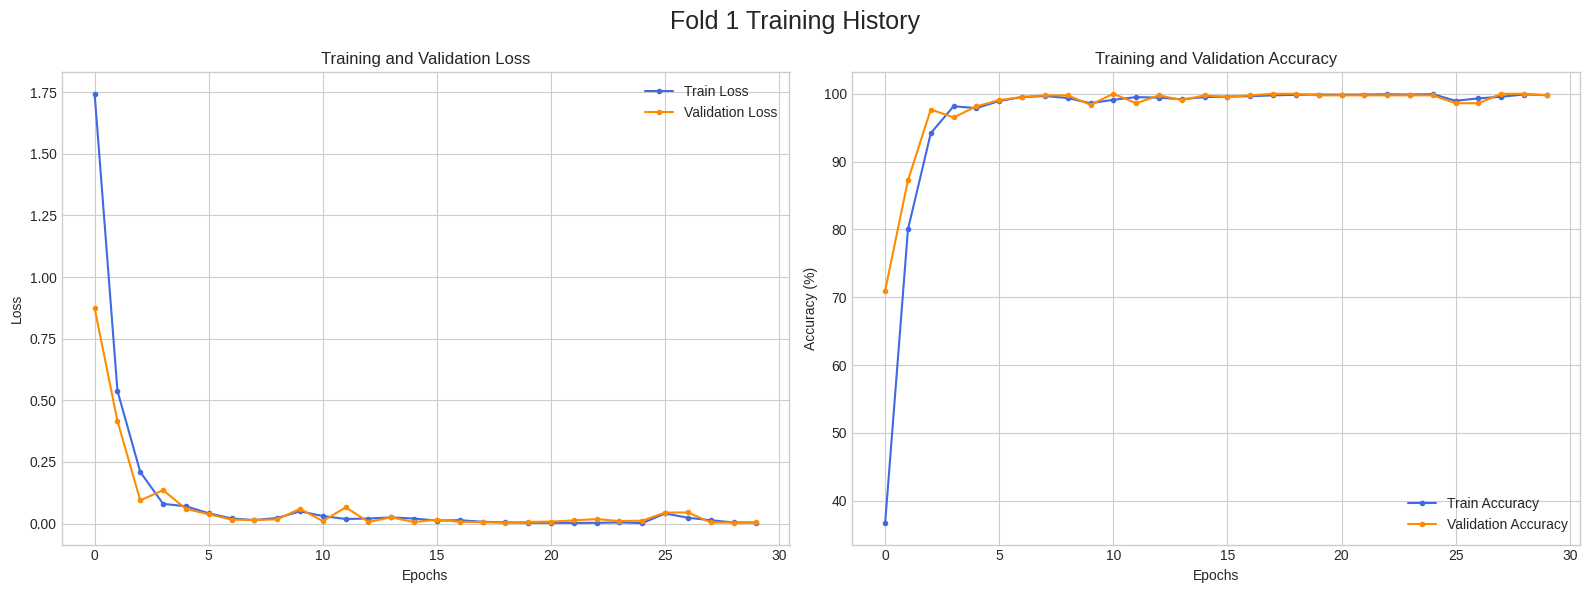

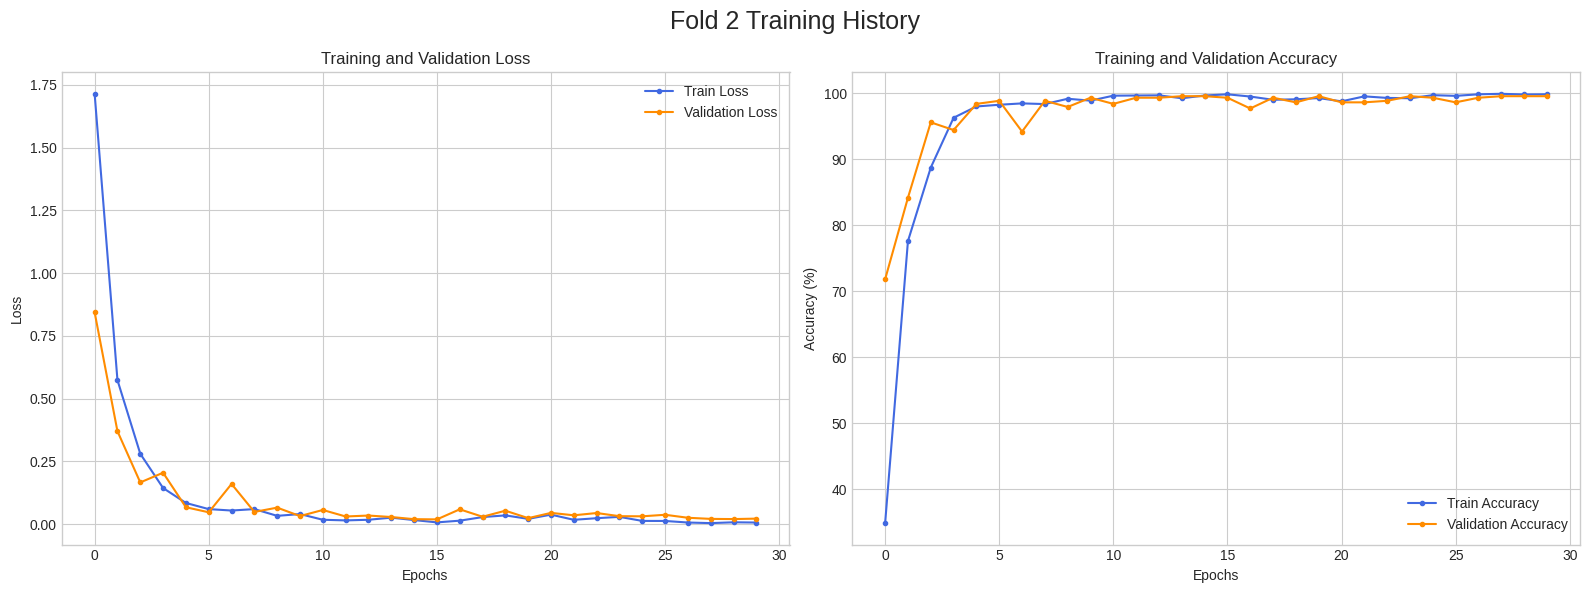

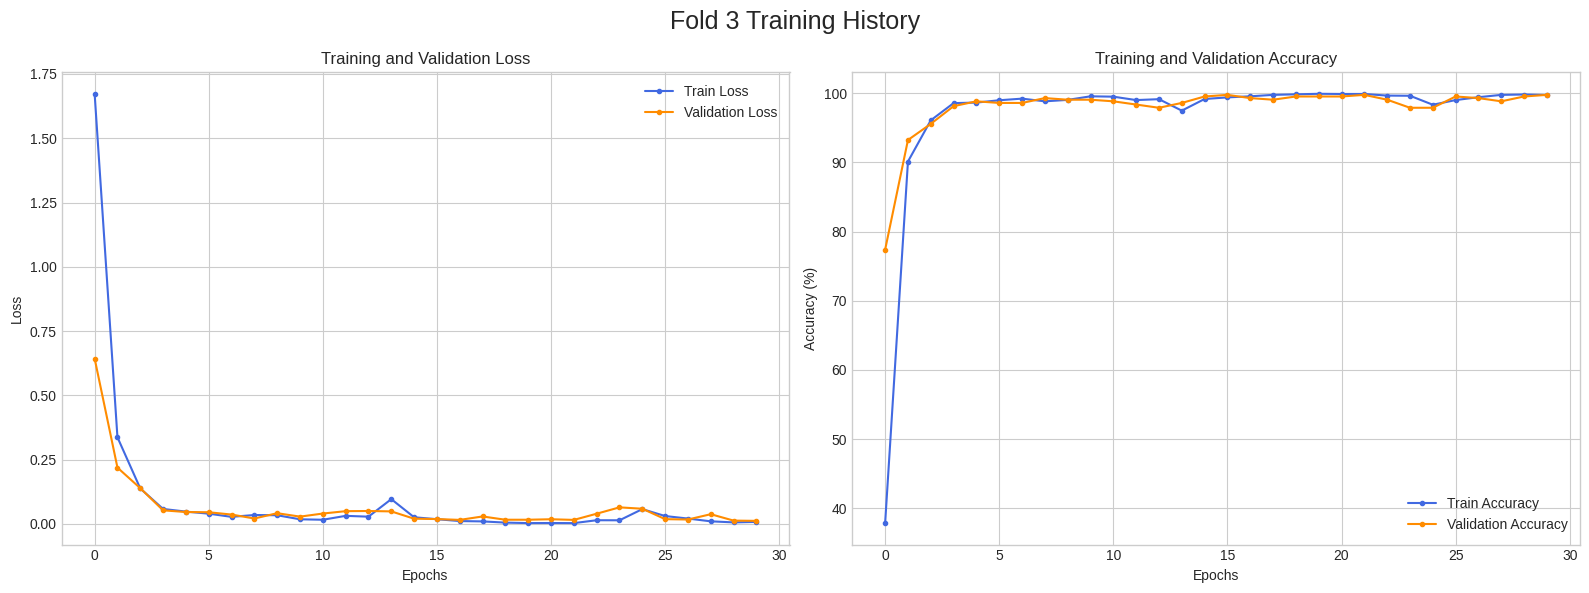

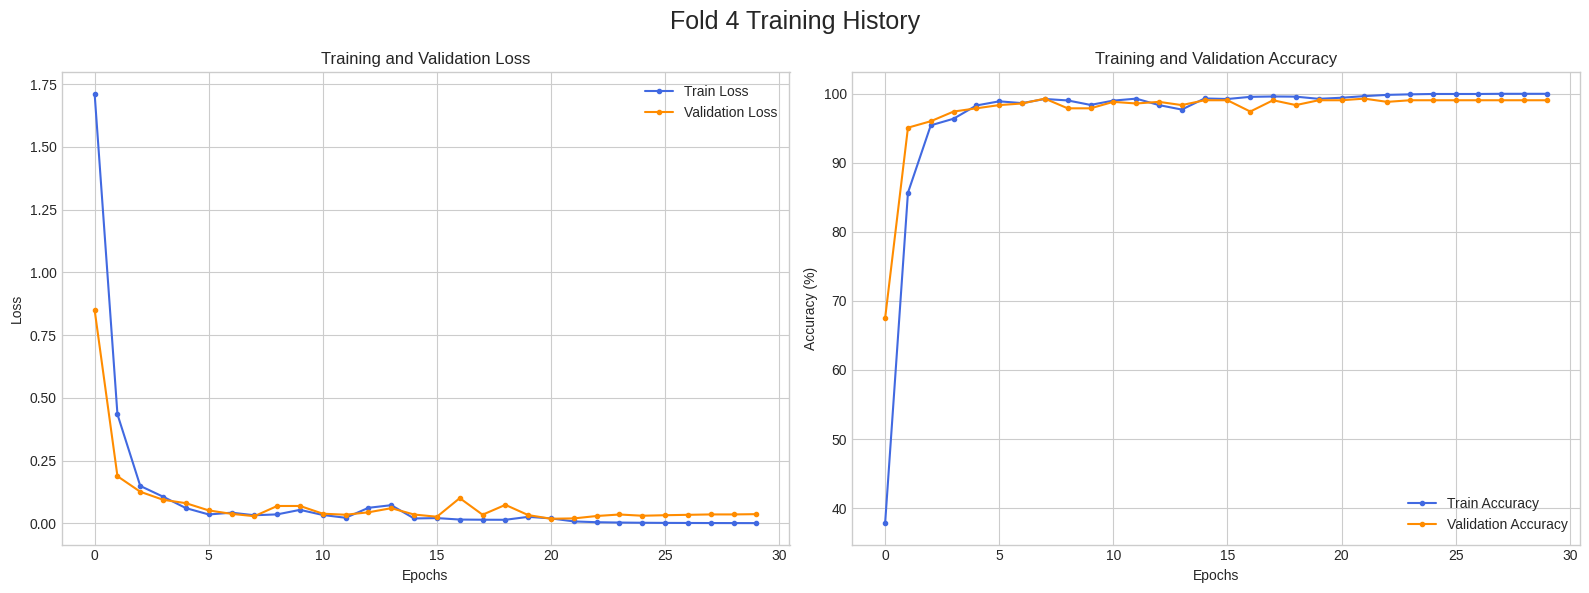

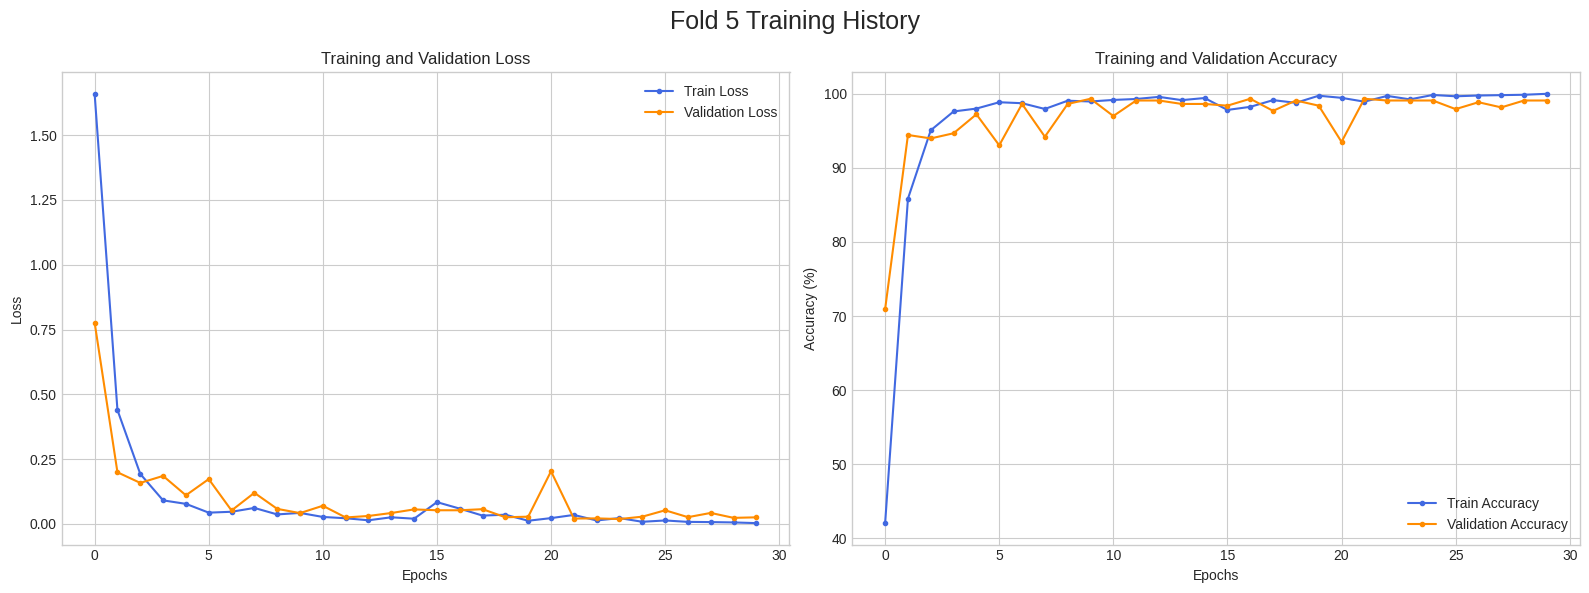

In [27]:
# --- 6. Training History Visualization ---
print("\n--- 6. Training History Visualization ---")
for i, history in enumerate(fold_results):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Fold {i+1} Training History', fontsize=18)

    ax1.plot(history['train_loss'], label='Train Loss', color='royalblue', marker='o', markersize=3)
    ax1.plot(history['val_loss'], label='Validation Loss', color='darkorange', marker='o', markersize=3)
    ax1.set_title('Training and Validation Loss'); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy', color='royalblue', marker='o', markersize=3)
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='darkorange', marker='o', markersize=3)
    ax2.set_title('Training and Validation Accuracy'); ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy (%)'); ax2.legend()

    plt.tight_layout(); plt.show()

In [28]:
# --- 7. Final Results ---
print("\n\n--- 7. Final Cross-Validation Results ---")
accuracies_np = np.array(fold_accuracies)
print(f"Accuracy per Fold: {accuracies_np}")
print(f"Average Accuracy: {accuracies_np.mean():.2f} %"); print(f"Standard Deviation of Accuracy: {accuracies_np.std():.2f}")



--- 7. Final Cross-Validation Results ---
Accuracy per Fold: [82.62511804 89.79591837 91.33271202 85.38390379 89.34579439]
Average Accuracy: 87.70 %
Standard Deviation of Accuracy: 3.21



--- 8. Classification Report & Confusion Matrix ---
                           precision    recall  f1-score   support

          Climbing stairs       0.89      0.99      0.94       483
                  Cycling       0.95      0.30      0.46       480
Frontal elevation of arms       0.99      1.00      1.00       480
                  Jogging       0.97      0.98      0.98       480
        Jump front & back       0.87      0.95      0.91       479
Knees bending (crouching)       0.95      0.96      0.96       442
               Lying down       0.70      0.99      0.82       460
                  Running       0.85      0.93      0.89       458
     Sitting and relaxing       0.99      1.00      0.99       480
           Standing still       0.80      0.77      0.78       480
      Waist bends forward       0.77      0.80      0.78       480
                  Walking       0.98      0.87      0.92       159

                 accuracy                           0.88      5361
       

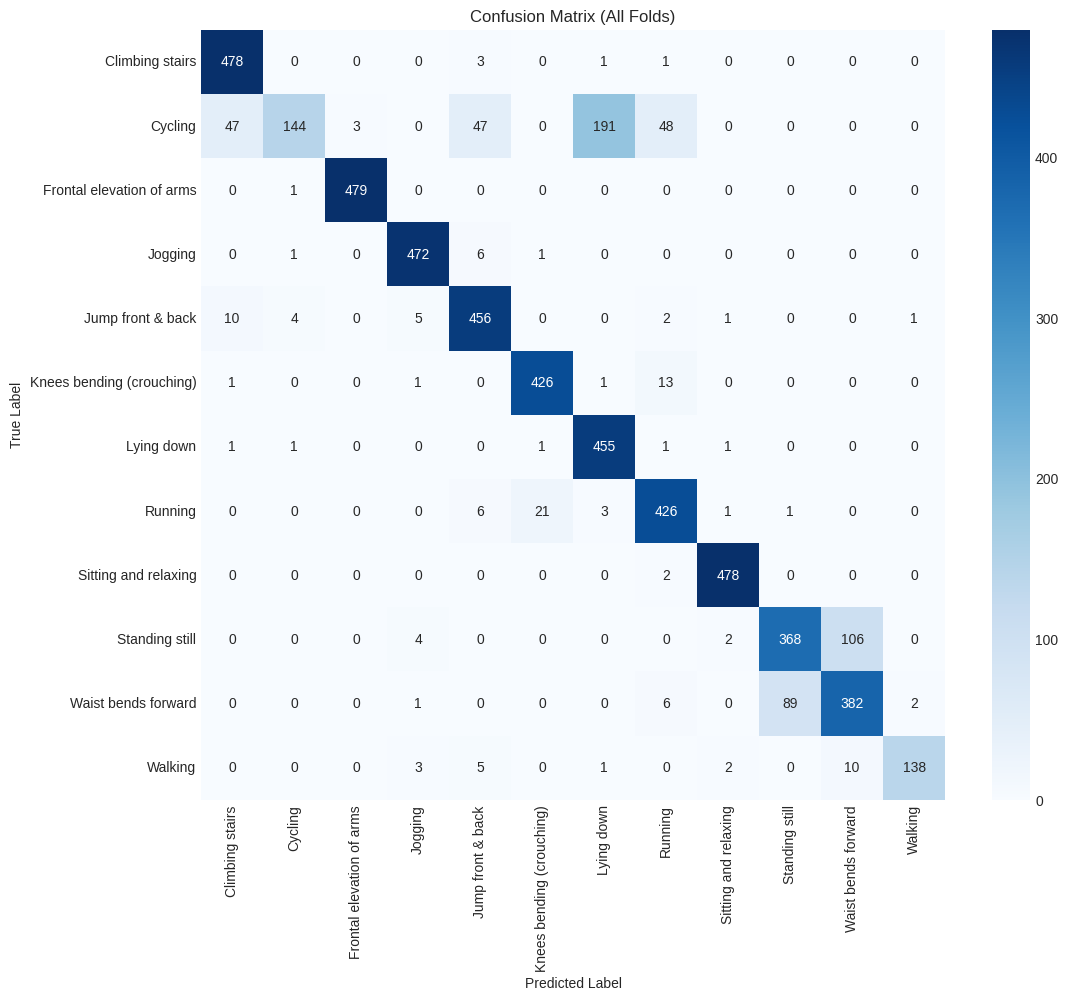

In [29]:
# --- 8. Classification Report & Confusion Matrix ---
print("\n--- 8. Classification Report & Confusion Matrix ---")
target_names_actual = [le.classes_[i] for i in sorted(np.unique(y))]

print(classification_report(all_labels, all_preds, target_names=target_names_actual))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names_actual, yticklabels=target_names_actual)
plt.title('Confusion Matrix (All Folds)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()